In [1]:
%load_ext autoreload
%autoreload 2

## Designated problem

Let us think of a problem involving a cylindrical solid body cooling in an open environment. We can think of this as a coffee cup cooling with the environment. Therefore, the environmental temperature is defined as $T_{{env}}$ and the temperature of the hot liquid at a time $t=0$ given as $T_0$. The governing equation for this relation is,

$$\frac{dT}{dt} = R \times (T - T_{env})$$

1. **Uniform Temperature throughout the Body**: The temperature \( T(t) \) is assumed to be uniform throughout the entire body of the coffee cup at any given time \( t \). This assumes efficient thermal conduction within the body of the cup.

2. **Thin-Walled Approximation**: If the coffee cup is thin-walled relative to its diameter, heat conduction through the walls can be approximated as instantaneous, meaning the temperature throughout the wall thickness is uniform.

3. **Isotropic Heat Conduction (if applicable)**: The coffee cup is assumed to conduct heat uniformly in all directions (isotropically), which simplifies the heat transfer analysis.

4. **Environment Size**: The size of the environment relative to the coffee cup is large enough such that the temperature ($T_{env}$) remains constant over time and does not significantly change due to the heat lost by the coffee cup.

6. **No Phase Change**: The material of the coffee cup and the liquid inside do not undergo phase changes (like boiling) during the cooling process. This assumption simplifies the analysis to a single-phase heat transfer process.

7. **Steady-State Conditions**: The system is assumed to be in a steady-state condition at the initial time \$t = 0$), where the temperature difference between the coffee cup and the environment drives the initial rate of cooling.

## Analytical solution

Since this is a linear differential equation a combination of homogeneous and particular solutions exists. Below solution calculates the temperature ($T$) of an object at a given time based on Newton's Law of Cooling. It uses the ambient temperature ($T_{{env}}$), the initial temperature ($T_0$), the coefficient of heat transfer ($R = \frac{hA}{C}$), and the elapsed time to compute the temperature.

$$T = T_{env} + (T_0 + T_{env}) \cdot e^{-Rt}$$

Suppose, a liquid has a temperature of 99 degrees at a $t = 0$. The environment temperature, $T_{env}$ measured as $25^o$. We would like to know the temperature evolution and time spent until the whole liquid temperature reaches an equilibrium with the environment temperature. However, the coefficient of heat transfer, $R$, should be supplied to the equation. Below, the solutions can be obtained via the functions.

(0.0, 0.0007271419313645293)

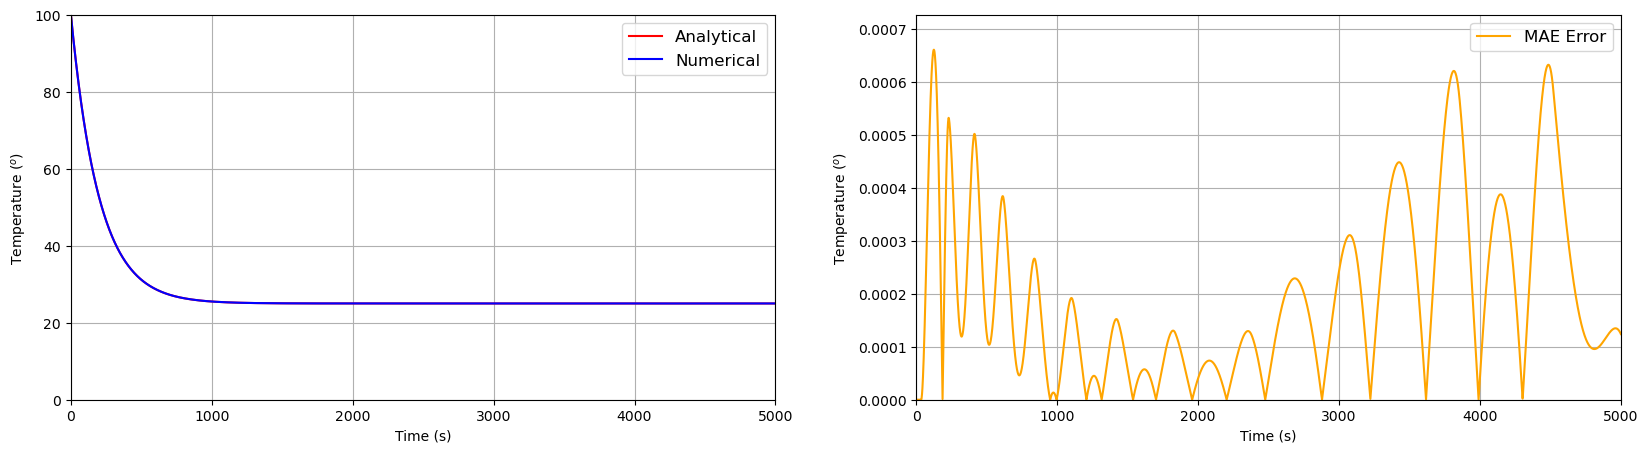

In [2]:
from soln import *
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame()

p = Soln(Tenv = 25, T0=100, cooling_rate = 0.005, t_start = 0.0, t_end = 5000.0, increment = 1.0)
data["time"] = p.get('time_data')
data["analytical"] = p.analytical_solution()
data["numerical"] = p.numerical_solution()
data["mae_error"] = abs((p.analytical_solution() -  p.numerical_solution()) / p.analytical_solution())

## Plotting of data
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
axs[0].plot(data["time"], data["analytical"], linestyle="solid", color="red", label="Analytical")
axs[0].plot(data["time"], data["numerical"], linestyle="solid", color="blue", label="Numerical")
axs[0].legend(loc='upper right', prop={'size': 12})
axs[0].set_xlim(0,data["time"].max())
axs[0].set_ylim(0,data["analytical"].max())
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Temperature ($^o$)")
axs[0].grid()

axs[1].plot(data["time"], data["mae_error"], linestyle="solid", color="orange", label="MAE Error")
axs[1].legend(loc='upper right', prop={'size': 12})
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Temperature ($^o$)")
axs[1].grid()
axs[1].set_xlim(0,data["time"].max())
axs[1].set_ylim(0,data["mae_error"].max()*1.1)

## Neural network approach to regenerate Newton's Law of Cooling
For this designated simple problem, the Newton Law of Cooling can be applied to understand the temperature evolution behavior. But, is it possible to give some of the data to the machine learning libraries and expect to extrapolate the variables with the same behavior?

To test this idea, we can use the PyTorch package to construct our neural network and test it. Since we are constructing the neural network by hand, it is possible to use functions of PyTorch library including optimizers.

### Train and test data
To train our cooling behavior described in our equation, training data on the first part of the curve can be used.

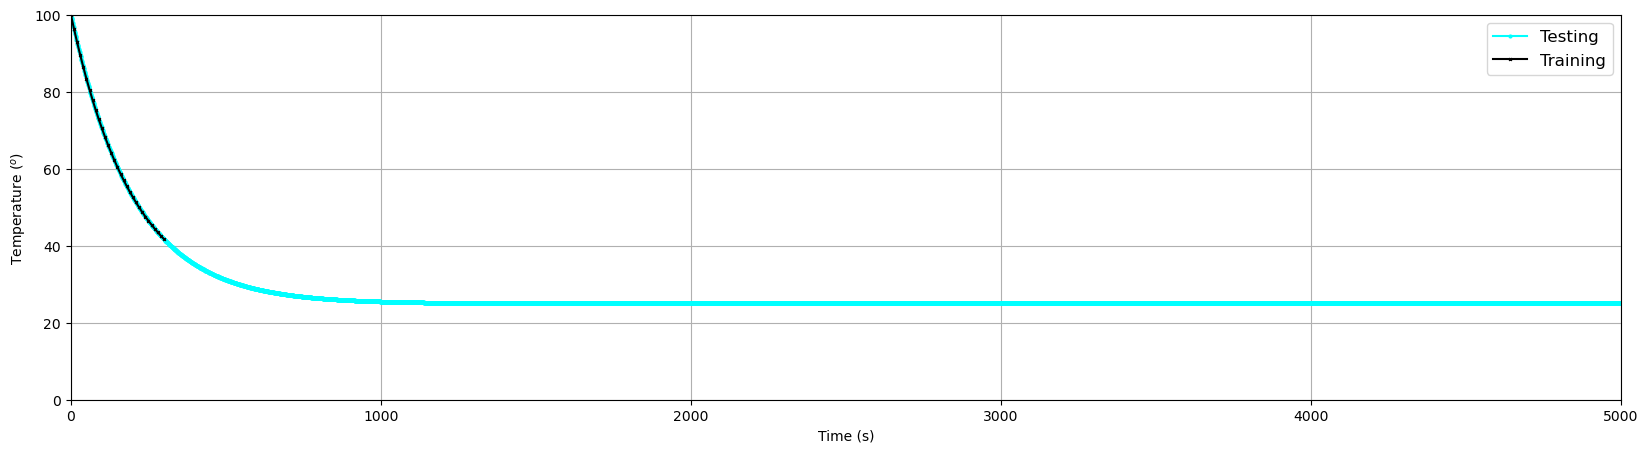

In [3]:
# Generate training data
get_values = list(range(int(0), int(300) + 1, int(10)))
training_data = data[data['time'].isin(get_values)]
training_data = training_data.reset_index()

# Generate testing data
testing_data = data[~data['time'].isin(get_values)]
testing_data = testing_data.reset_index()

# Plot training and testing data
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(20,5))
axs.plot(testing_data["time"], testing_data["analytical"], linestyle=None, marker="o", color="cyan", markersize = 2, label="Testing")
axs.plot(training_data["time"], training_data["analytical"], linestyle=None, marker="x", color="black", markersize = 2, label="Training")
axs.legend(loc='upper right', prop={'size': 12})
axs.set_xlim(0,data["time"].max())
axs.set_ylim(0,data["analytical"].max())
axs.set_xlabel("Time (s)")
axs.set_ylabel("Temperature ($^o$)")
axs.grid()

### Speed check with CPU and GPU
While training batches with PyTorch, it is often better to use GPU as a calculation for reducing execution time. However, the allocated memory on the GPU is important to estimate to ensure it can run. For instance, in the code below, generating a tensor with a size of 100k x 100k is impossible. It is because the memory that should be allocated on my GPU (8Gb) is insufficient. Therefore, I had to use CPU and my SWAP area for this operation because my memory was not sufficient (32Gb). Therefore, it is very important to check the capability of the GPU.

Another point is to determine at which point GPU passes CPU. For instance, a tensor with 100 x 100, won't any faster if it is generated in the GPU compared to CPU. At least, on my machine, it took same amount of time. Therefore, if there is a big batch and GPU is capable, then it is better to use GPU. 

In [ ]:
from functools import wraps
import time
import torch

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

@timeit
def torch_ones(x_dim, y_dim, device = "cpu"):
    device = torch.device(device)
    print('Using device:', device)
    total = torch.ones(x_dim, y_dim, device=device)
    return total

torch_ones(100,100,device = "cuda")

### Import necessary libraries and run a neural network application
Let's start with including the necessary libraries. This code snippet is also used to automatically determine and display the computing device being used by PyTorch, either a CUDA-enabled GPU or the CPU. It first checks if a CUDA-capable GPU is available and sets the device accordingly. If a GPU is being used, it prints the GPU's name and the memory usage, including the amount of memory allocated and reserved (cached) in gigabytes. This is useful for monitoring and debugging purposes in deep learning applications to ensure that the GPU resources are being utilized correctly. 
* The class Net defines a neural network in PyTorch, with configurable input and output dimensions, hidden units, loss functions, learning rate, and training epochs. The network architecture consists of several ReLU-activated linear layers. The fit method trains the network using the Adam optimizer, while optionally considering a secondary loss term. The predict method outputs the network's predictions for given input data. 
* The NetDiscovery class extends the Net class, inheriting its neural network structure and training functionality. In addition to the inherited attributes, it introduces a new learnable parameter r.

In [4]:
from nn import Net, NetDiscovery

## Construct the neural network
net = Net(input_dim = 1, output_dim = 1, 
          loss2=None, epochs=20000, lr=1e-5)

Using device: cuda
NVIDIA T1000 8GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
## Assign the computation to GPU or CPU
## If required to change the device than use
## net.set_device("cpu") or net.set_device("cuda")
## Before the line below
net = net.to(net.get_device())

## There is not a big difference between GPU and CPU
## Unless the tensor size gets bigger

## Calculate losses
losses = net.fit_tqdm(training_data["time"].values, training_data["analytical"].values)

Training Progress: 100%|██████████████████████████████████████| 20000/20000 [00:14<00:00, 1340.16it/s]


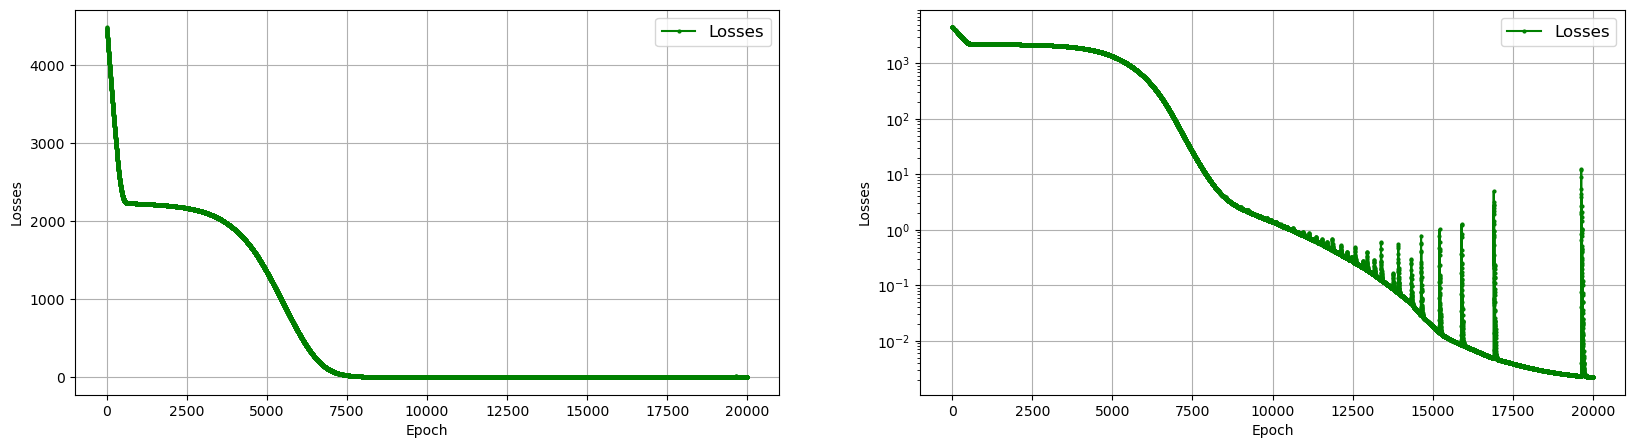

In [10]:
## Plot losses
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
axs[0].plot(losses, linestyle=None, marker="o", color="green", markersize = 2, label="Losses")
axs[0].legend(loc='upper right', prop={'size': 12})
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Losses")
axs[0].grid()

axs[1].plot(losses, linestyle=None, marker="o", color="green", markersize = 2, label="Losses")
axs[1].legend(loc='upper right', prop={'size': 12})
axs[1].set_yscale('log')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Losses")
axs[1].grid()

#plt.plot(losses)
#plt.yscale('log')

### Re-running the neural network with l2 regularization
This time, we will add a l2 regularization on neural network by using the function 'l2_reg'.
If you run the code below, you can sense that the execution time of the same code increased. It is because, on each epoch we have to access a function and make calculations.

In [12]:
from nn import l2_reg

## Construct the neural network
net_l2 = Net(input_dim = 1, output_dim = 1, 
             epochs=20000, lr=1e-5,
             loss2=l2_reg, loss2_weight = 1.)

Using device: cuda
NVIDIA T1000 8GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [13]:
## Assign the computation to GPU or CPU
## If required to change the device than use
## net.set_device("cpu") or net.set_device("cuda")
## Before the line below
net_l2 = net_l2.to(net.get_device())

## There is not a big difference between GPU and CPU
## Unless the tensor size gets bigger

## Calculate losses
losses_l2 = net_l2.fit_tqdm(training_data["time"].values, training_data["analytical"].values)

Training Progress: 100%|███████████████████████████████████████| 20000/20000 [00:23<00:00, 855.74it/s]


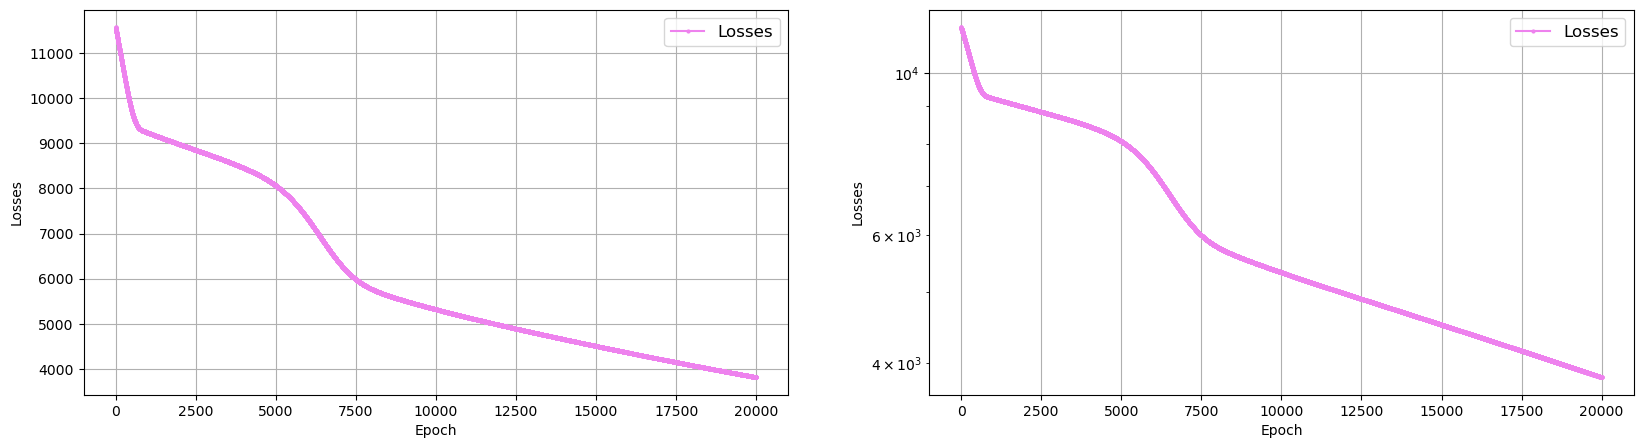

In [14]:
## Plot losses
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
axs[0].plot(losses_l2, linestyle=None, marker="o", color="violet", markersize = 2, label="Losses")
axs[0].legend(loc='upper right', prop={'size': 12})
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Losses")
axs[0].grid()

axs[1].plot(losses_l2, linestyle=None, marker="o", color="violet", markersize = 2, label="Losses")
axs[1].legend(loc='upper right', prop={'size': 12})
axs[1].set_yscale('log')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Losses")
axs[1].grid()

Compared to l1 regularization, it seems that we require more epoch to reach stability on the losses. But, for the sake of simplicity, we leave the results as it is.

## Function -> grad
The grad function computes the partial derivative of an output tensor with respect to an input tensor using PyTorch's autograd. It takes an output tensor of shape (N, 1) and an input tensor of shape (N, D) and returns the gradients, enabling gradient computation for further operations.

In [ ]:
def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

## Classical network from torch

In [ ]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [ ]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## PINN

In [ ]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    # pde = R*(Tenv - temps) - dT
    for i in range(len(dT)):
        if dT[i][0].item() < 0:
            dT[i][0] = 0
    return torch.mean(dT**2)

In [ ]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

In [ ]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## Parameter Discovery

In [ ]:
def physics_loss_discovery(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = model.r * (Tenv - temps) - dT
    
    return torch.mean(pde**2)

In [ ]:
netdisc = NetDiscovery(1, 1, loss2=physics_loss_discovery, loss2_weight=1, epochs=40000, lr= 5e-6).to(DEVICE)

losses = netdisc.fit(t, T)
plt.plot(losses)
plt.yscale('log')

In [ ]:
preds = netdisc.predict(times)
print(netdisc.r)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'discovery PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')